# Binary Search Trees

## Introduction

- Think of BSTs as a data structure optimised for local search
    - For example, find all words starting with some string, or emails within some period

- A local search data must support 2 operations:
    - `RangeSearch(x,y)`: Return all elements with keys between $x$ and $y$
    - `NearestNeighbours(z)`: Return all elements with keys on either side of some entry $z$
    - `Insert`: Insert an element with key x in the right place
    - `Delete`: Remove element with key x
    - Examples: [1,4,6,7,10,13,15]
        - Insert(3): [1,3,4,6,7,10,13,15]
        - Delete(3): [1,4,6,7,10,13,15]
        - NearestNeighbours(7): (6,10)
        - RangeSearch(5,12): (6,7,10)

- Can these operations be supported by existing data structures?
    - Hash Table
        - `RangeSearch(x,y)`: No way to iterate through the keys. Hashtables are optimised for fast retrieval
        - `NearestNeighbours(z)`: Same thing, no easy way to iterate through the keys
        - `Insert`: O(1)
        - `Delete`: O(1)
    - Array
        - `RangeSearch(x,y)`: O(N), because we need to iterate through all items and check for value between x and y
        - `NearestNeighbours(z)`: O(N), need to iterate through all array values to find the right one
        - `Insert`: O(1)
        - `Delete`: O(1)
    - Sorted Array
        - `RangeSearch(x,y)`: O(log(N)), because we can binary search due to sorted array
        - `NearestNeighbours(z)`: O(log(N)), because we can binary search due to sorted array
        - `Insert`: O(N), When inserting a new value, we need to binary search to find the right position, then copy all objects to its right 1 space to the right
        - `Delete`: O(N), When deleting a value, we need to binary search to find the right position, then copy objects to its right 1 space to the left
    - Linked List
        - `RangeSearch(x,y)`: O(N), because we need to traverse the entire list to identify which elements are in the range
        - `NearestNeighbours(z)`: O(N), because we need to traverse the entire list to definitively conclude what the neighbours actually are 
        - `Insert`: O(1)
        - `Delete`: O(1)

## Search Trees

- Consider binary search; we want to halve the search space in each iteration
    - This is a natural analogue of a search tree, where for every given node $N$, all values in left subtree are less than $N$, and all values to the right are more than $N$
    - If the tree is balanced, that means each traversal decision halves the remaining search space!

- Every tree has 
    - Root node
    - Left subtree (smaller)
    - Right subtree (larger)

- Every node has
    - Key
    - Parent
    - Left child
    - Right child

## Search tree operations

In [8]:
from dataclasses import dataclass
from typing import Union, Optional

@dataclass
class Node:
    key: int
    parent: Optional['Node']
    left_child: Optional['Node']
    right_child: Optional['Node']

### Find

- `Find`
    - With inputs as key $k$ and root node $R$, output the node in the tree with key $k$
    - Depending on the value of the key at the curr node, either return the current node, or recursively call the left child (if current node value > $k$), or recursively return the right child (if current node value < $k$)

    - One interesting thing to note is what happens when the value isn't in the tree
        - Then, the position you reach before you hit `None` is exactly where the key you are looking for should be!
        - For convenience, let's return it if you hit a `None` case

In [1]:
def find(k: int, root: Node) -> Node:
    if root.key == k:
        return root
    elif root.key > k:
        if root.left_child is not None:
            return find(k, root.left_child)
        return root
    else:
        if root.right_child is not None:
            return find(k, root.right_child)
        return root

### Next

- `Next`
    - With input node `N`, output the node in the tree with the next largest key

    - Approach
        - If `N` has a right child, return the left-most left descendent of the right child
            - Traverse to the right child, then keep traversing leftwards until you hit null. The value before the null is the next largest key
        - If `N` has no right child, then the only way to have a Node with value that exceeds `N` is among its parent/grandparent/etc.
            - Suppose `N_parent.key` is smaller than `N.key`
                - Then we have not found the next greatest value, and we continue looking upwards recursively
            - Suppose `N_parent.key` is larger than `N.key`
                - Let the value of the grandparent node be `N_grandparent`
                - Can `N` < `N_grandparent` < `N_parent`?
                - This cannot be possible. If `N_parent` > `N_grandparent`, it must be on the right of `N_grandparent`, which means that `N > N_grandparent`
                - So as long as we know that `N_parent` > `N`, there is no need to search further! Because all parents of `N_parent` must either be larger than both `N_parent` and `N`, or smaller than both `N_parent` and `N`. 
        - If there are no larger values than `N` among the nodes above `N`, and there are no right childs from `N`, then `N` must be the largest value in the tree

In [3]:
def get_leftmost_descendent(n: Node) -> Node:
    if n.left_child is not None:
        return get_leftmost_descendent(n.left_child)
    else:
        return n

def get_first_larger_ancestor(n: Node) -> Node:
    if n.parent is not None:
        if n.parent.key > n.key:
            return n.parent
        else:
            return get_first_larger_ancestor(n.parent)
    return n

def next(n: Node) -> Node:
    if n.right_child is not None:
        return get_leftmost_descendent(n.right_child)
    else:
        return get_first_larger_ancestor(n)
        

### Range Search

- `RangeSearch`
    - Given numbers $x$ and $y$ and root node $R$, output a list of nodes with key between $x$ and $y$

    - Approach
        -  `Find` the first element in the range $(x, y)$ by finding $x$. 
            - If $x$ doesn't exist, it will return the position where $x$ is supposed to be. Then get the value of the node
            - Append the value of the node to an array
            - Keep running `Next` and appending the key value until key value exceeds $y$
        - Then, you have an array of values in the range $(x,y)$

In [4]:
def range_search(x: int, y: int, R: Node) -> list[int]:
    curr_node: Node = find(x, R)
    range_arr: list[int] = [curr_node.key]
    while curr_node.key <= y:
        curr_node: Node = next(curr_node)
        range_arr.append(curr_node.key)
    return range_arr

### Insert

- `Insert`
    - Given key $k$ and root node $R$, add node with key $k$ to the tree

    - Approach
        - Recall that our `find` function returns the "correct" position $P$ for a value $k$, if it is unable to find it!
        - So all we need to do is to append a new node of key $k$ as a child of that node at $P$

In [5]:
def insert(k: int, R: Node) -> None:
    append_to_node: Node = find(k, R) 
    new_node: Node = Node(k, append_to_node, left_child=None, right_child=None)
    if append_to_node.key > k:
        append_to_node.left_child = new_node
    else:
        append_to_node.right_child = new_node

### Delete

- `Delete`
    - Given node $N$, remove from tree

    - Approach
        - The difficulty is that you can't just delete, else the parent of $N$ won't have a child, and the children of $N$ won't have a parent
        - Let's think through the solution step by step: For any node $N$ we wish to remove, there are 3 cases to consider
            1. $N$ has no children
                - In this case, you can simply delete the node, and remove reference from its pareent
            2. $N$ has 1 child
                - If node $N$ has only a left child OR right child, you can simply promote it to $N$'s position
                    - Why? 
                        - Imagine $N$ is a root node
                        - Everything after $N$ must be a valid BST, whether the single child is on the right or left.
                        - That is, if $N$ is a left child, then all values below $N$ in the tree must be less than $N$ AND it's parent
                        - If $N$ is a right child, all values below $N$ in the tree must be greater than $N$ and its parent
                        - So simply promoting the next node after $N$ will continue to give us a valid tree, since nothing changes! 
            3. $N$ has 2 children
                - If node $N$ has both a left and right child, you cannot just promote one. 
                    - Why? Because if you simply promote one subtree, you will lose access to the other subtree
                - So what can you do? Remember, you are trying to find a way to replace $N$, while maintaining the BST property
                - Recall that 
                    - all values in the left subtree must be less than $N$, and less than everything from the right_child of $N$
                    - all values in the right subtree must be greater than than $N$, and greater than everything from the left_child of $N$ 
                - From the 2 insights above, we can 
                    - Promote the maximum value to the left of $N$ to $N$'s position, which will always retain BST since it must be less than the right child of $N$, but more than everything else in the left subtree
                    - Promote the minimum value to the right of $N$ to $N$'s position, which will always retain BST since it must be greater than the left child of $N$, but less than everything else in the right subtree
                - But notice that
                    - The max value of the left subtree must necessarily not have a right node. So it has either 0 or 1 children
                    - The min value of the right subtree must necessarily not have a left node. So it has either 0 or 1 children
                - So after we promote either option, we can simply perform either case 1 or case 2 above
                        
                        


In [ ]:
def get_max_in_subtree(N: Node) -> Node:
    if N.right_child is not None:
        return get_max_in_subtree(N.right_child)
    else:
        return N

def delete(n: Node) -> None:    
    if (n.left_child is None) and (n.right_child is None):
        if n.parent is not None:
            if n.key > n.parent.key:
                n.parent.right_child = None
            elif n.key < n.parent.key:
                n.parent.left_child = None
    elif n.left_child is not None:
        if n.parent is not None:
            n.parent.left_child = n.left_child

    elif n.right_child is not None:
        if n.parent is not None:
            n.parent.right_child = n.right_child

    ## If both are not none, we just choose the max from the left hand side
    elif (n.left_child is not None) and (n.right_child is not None):
        if n.parent is not None:
            max_node_left_subtree = get_max_in_subtree(n)
            n.left_child.parent = max_node_left_subtree
            n.right_child.parent = max_node_left_subtree
            
            if n.parent.key > max_node_left_subtree.key:
                n.parent.left_child = max_node_left_subtree
            else:
                n.parent.right_child = max_node_left_subtree
            
            if (max_node_left_subtree.left_child is not None) and (max_node_left_subtree.parent is not None):
                max_node_left_subtree.parent.right_child = max_node_left_subtree.left_child

## Runtime/Balance

- How long does each of the operations take to run?

- `Find`: $O(\text{tree depth}) = O(\log(N))$
    - We are iteratively doing binary search, so if the tree is balanced, then the search time is simply the height of the tree, which is $\log(N)$
    - If the tree is not balanced (e.g. a single long chain), then run time is obviously $O(N)$

- BUT insertions and deletions can destroy subtree balance. How do we fix this?

- We can rearrange the tree to maintain balance. 
    - We do this using this idea called **Rotations**

- We'll study the actual balancing in the next chapter. But let's do a trivial example of rotating a BST by translating the operation below into code

- Visualise this as "rotating" the outermost layer (A Y X C) clockwise, then swapping the connection of the inner layer 

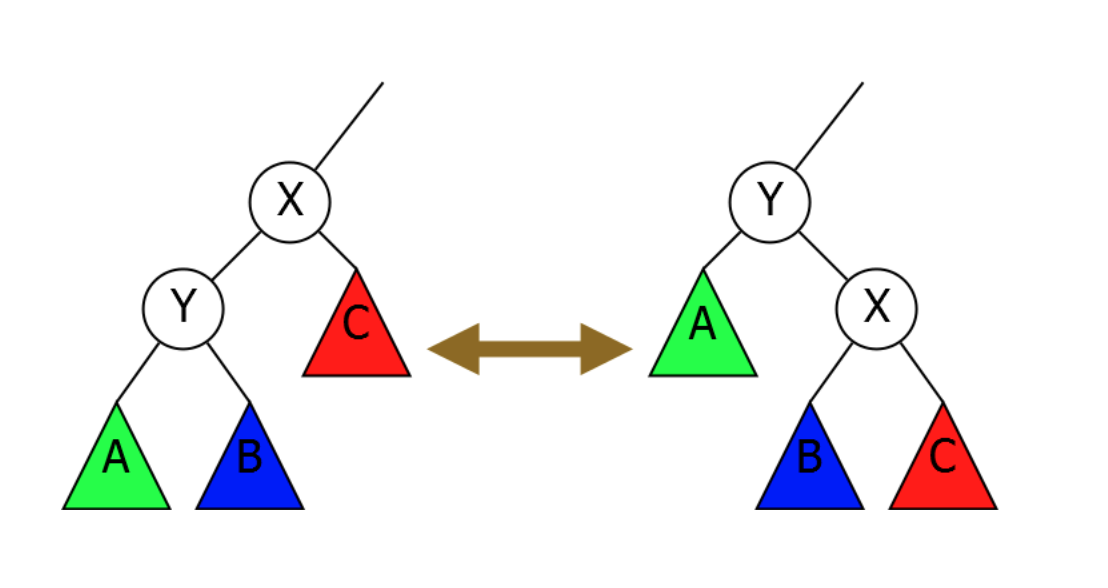

In [6]:
def rotate_tree(X: Node):
    assert X.left_child is not None
    assert X.right_child is not None
    assert X.parent is not None

    assert X.left_child.left_child is not None
    assert X.left_child.right_child is not None

    ## Sort out the new assignments from top down in the tree
    parent: Node = X.parent
    parent.left_child = X.left_child

    Y = X.left_child
    B = Y.right_child 

    Y.parent = parent
    Y.right_child = X
    
    X.left_child = B
    X.parent = Y

    B.parent = X
    